# Data Preprocessing


- **Binning (Sum)**: All spectra are binned uniformly (sum) from range [100-1500] with step 0.02  
- **Normalization**: TIC



In [35]:
from pyimzml.ImzMLParser import ImzMLParser
import numpy as np
import random
import matplotlib.pyplot as plt
import math


p = ImzMLParser('../Data/LPS/Control1.imzml')

my_spectra = []
for idx, (x,y,_) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities,(x,y)])

print(f"Total spectra loaded: {len(my_spectra)}")


Total spectra loaded: 1636


In [36]:
# determine the index of the spectrum with min len(mzs)
min_len_idx = np.argmin([len(spectrum[0]) for spectrum in my_spectra])
print(f"Index of spectrum with minimum m/z points: {min_len_idx}")


Index of spectrum with minimum m/z points: 588


In [ ]:
# from scipy.interpolate import interp1d

# # Define uniform m/z grid
# min_mz_uniform = 150  # Start from 100 as mentioned in your description
# max_mz_uniform = 2000  # End at 1500 as mentioned
# step_size = 0.02
# common_mzs = np.arange(min_mz_uniform, max_mz_uniform + step_size, step_size)

# print(f"Uniform m/z grid: {len(common_mzs)} points from {min_mz_uniform} to {max_mz_uniform}")

# # Interpolate each spectrum to the common m/z grid
# interpolated_spectra = []

# for idx, (mzs, intensities, (x, y)) in enumerate(my_spectra):
#     # Only use data within our target range
#     mask = (mzs >= min_mz_uniform) & (mzs <= max_mz_uniform)
#     mzs_filtered = mzs[mask]
#     intensities_filtered = intensities[mask]
    
#     if len(mzs_filtered) < 2:  # Need at least 2 points for interpolation
#         print(f"Warning: Spectrum {idx} has insufficient data points in range")
#         interpolated_intensities = np.zeros(len(common_mzs))
#     else:
#         # Create interpolation function
#         # Use 'linear' interpolation with bounds_error=False to handle extrapolation
#         interp_func = interp1d(
#             mzs_filtered, 
#             intensities_filtered, 
#             kind='linear', 
#             bounds_error=False, 
#             fill_value=0.0  # Fill with 0 for m/z values outside the spectrum range
#         )
        
#         # Interpolate to common m/z grid
#         interpolated_intensities = interp_func(common_mzs)
    
#     interpolated_spectra.append(interpolated_intensities)
    
#     if idx % 1000 == 0:  # Progress indicator
#         print(f"Processed {idx}/{len(my_spectra)} spectra")

# print(f"Interpolation complete! All {len(interpolated_spectra)} spectra now have {len(common_mzs)} uniform m/z points")

# # Verify interpolation worked
# print(f"Original spectrum 0 had {len(my_spectra[0][0])} m/z points")
# print(f"Interpolated spectrum 0 has {len(interpolated_spectra[0])} m/z points")

Uniform m/z grid: 92501 points from 150 to 2000
Processed 0/1636 spectra
Processed 1000/1636 spectra
Interpolation complete! All 1636 spectra now have 92501 uniform m/z points
Original spectrum 0 had 2669 m/z points
Interpolated spectrum 0 has 92501 m/z points


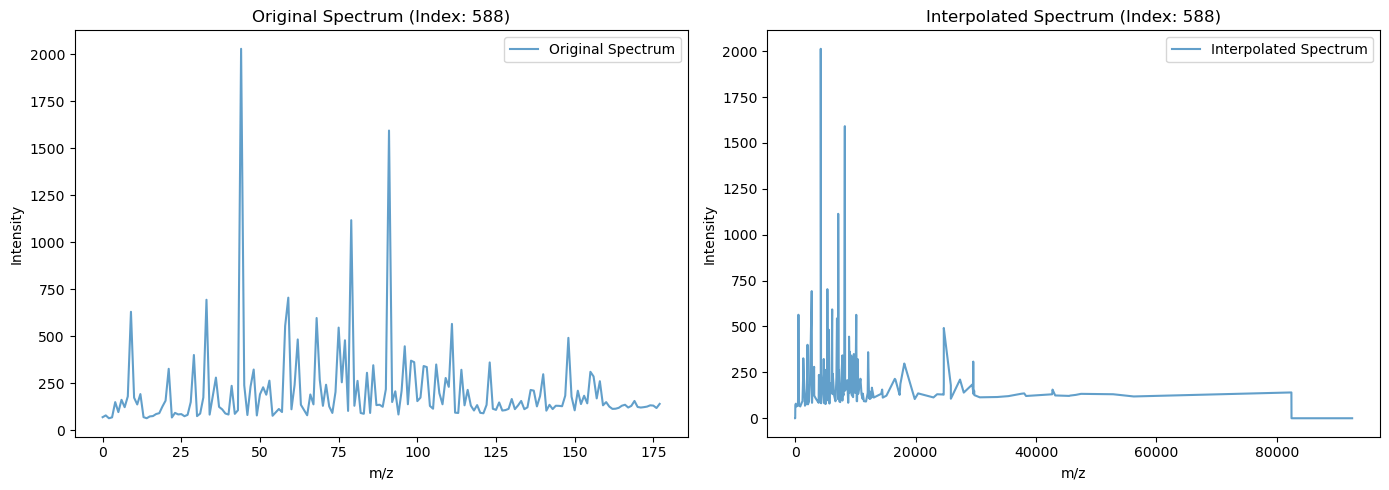

In [ ]:
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot( my_spectra[min_len_idx][1], label='Original Spectrum', alpha=0.7)
# plt.xlabel('m/z')
# plt.ylabel('Intensity')
# plt.title('Original Spectrum (Index: {})'.format(min_len_idx))
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(interpolated_spectra[min_len_idx], label='Interpolated Spectrum', alpha=0.7)
# plt.xlabel('m/z')
# plt.ylabel('Intensity')
# plt.title('Interpolated Spectrum (Index: {})'.format(min_len_idx))
# plt.legend()

# plt.tight_layout()
# plt.show()



In [52]:
max_mz = -float('inf')
min_mz = float('inf')
for spectrum in my_spectra:
    max_mz = math.ceil(max(max(spectrum[0]),max_mz))
    min_mz = math.floor(min(min(spectrum[0]),min_mz))
print(f'Range of mz values:',(min_mz,max_mz))


common_mzs = np.arange(min_mz,max_mz,0.02)
binned = np.zeros((len(my_spectra), len(common_mzs)), dtype=np.float32)

for i, (mzs, intensities,_) in enumerate(my_spectra):
    indices = np.digitize(mzs, common_mzs) - 1
    for k, val in zip(indices, intensities):
        if 0 <= k < binned.shape[1]:
            binned[i, k] += val


tic = binned.sum(axis=1, keepdims=True)
X = binned / (tic + 1e-6) 

# Min-max normalization to [0, 1] range per pixel
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-6) 

X = X.astype(np.float16)
print(f'X shape: {X.shape}, dtype: {X.dtype}, min: {X.min()}, max: {X.max()}')

Range of mz values: (150, 2000)
X shape: (1636, 92500), dtype: float16, min: 0.0, max: 1.0


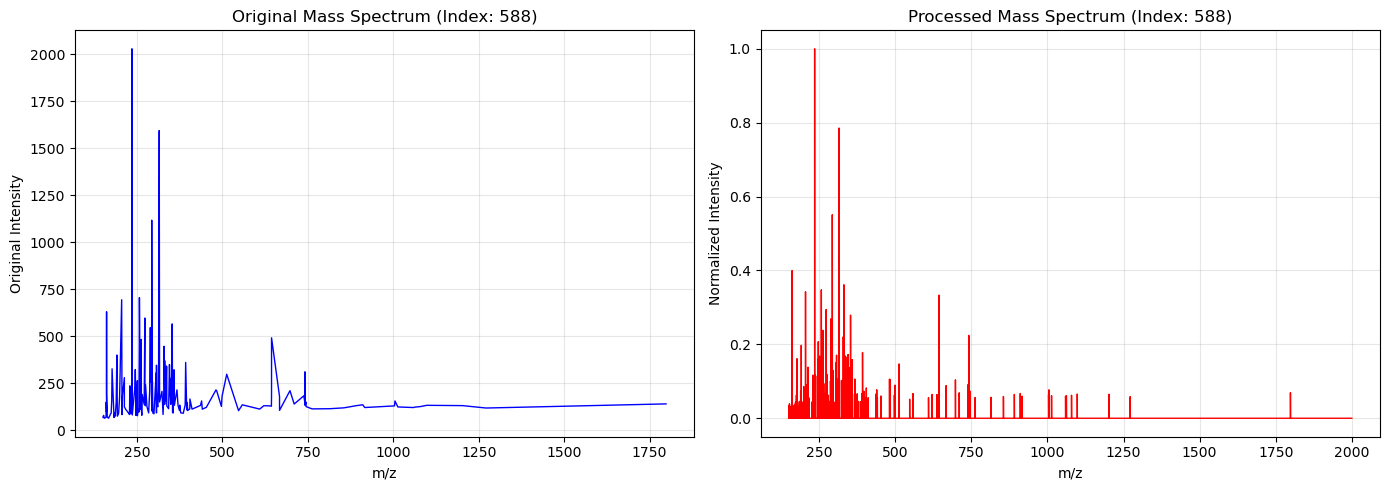

Original spectrum: 178 m/z points
Processed spectrum: 92500 m/z points
Original m/z range: 150.30 - 1798.25
Processed m/z range: 150.00 - 1999.98


In [57]:

# Plot a random spectrum
# Plot original and processed spectra side by side
spectrum_idx = min_len_idx

plt.figure(figsize=(14, 5))

# Original spectrum
plt.subplot(1, 2, 1)
plt.plot(my_spectra[spectrum_idx][0], my_spectra[spectrum_idx][1], linewidth=1.0, color='blue')
plt.xlabel('m/z')
plt.ylabel('Original Intensity')
plt.title(f'Original Mass Spectrum (Index: {spectrum_idx})')
plt.grid(True, alpha=0.3)

# Processed/normalized spectrum
plt.subplot(1, 2, 2)
plt.plot(common_mzs, X[spectrum_idx], linewidth=1.0, color='red')
plt.xlabel('m/z')
plt.ylabel('Normalized Intensity')
plt.title(f'Processed Mass Spectrum (Index: {spectrum_idx})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some comparison info
print(f"Original spectrum: {len(my_spectra[spectrum_idx][0])} m/z points")
print(f"Processed spectrum: {len(X[spectrum_idx])} m/z points")
print(f"Original m/z range: {my_spectra[spectrum_idx][0].min():.2f} - {my_spectra[spectrum_idx][0].max():.2f}")
print(f"Processed m/z range: {common_mzs.min():.2f} - {common_mzs.max():.2f}")

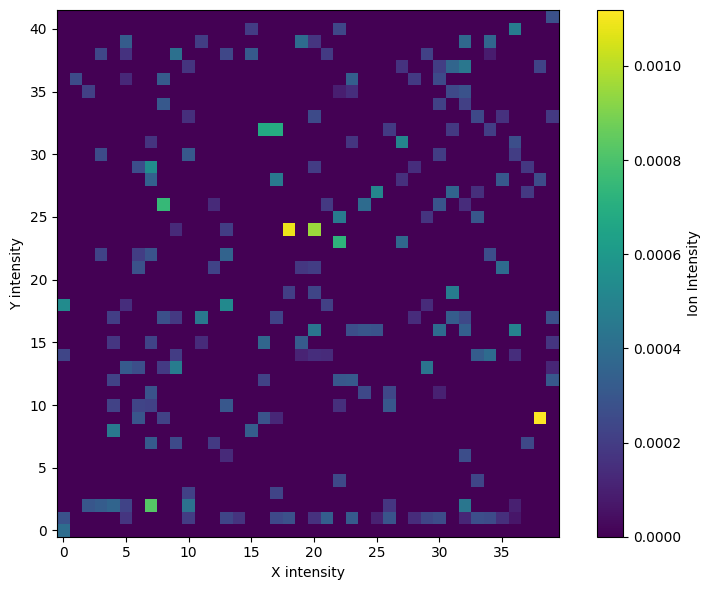

In [45]:
# Extract the slice of interest
slice_data = X[:, :, 0] + X[:,:,1]



# Create a scatter plot
# plt.figure(figsize=(10, 8))
# plt.scatter(
#     np.repeat(np.arange(slice_data.shape[1]), slice_data.shape[0]),  # x-coordinates (columns)
#     np.tile(np.arange(slice_data.shape[0]), slice_data.shape[1]),   # y-coordinates (rows)
#     c=slice_data.flatten(),                                         # color based on values
#     cmap='viridis',                                                 # colormap                                                           # marker size
# )
# plt.colorbar(label='Normalized Intensity')
# plt.xlabel('Pixel X Coordinate')
# plt.ylabel('Pixel Y Coordinate')
# plt.title('Scatter Plot of Pixel Intensities')
# plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
# plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(slice_data, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()

42 41
Points found 11


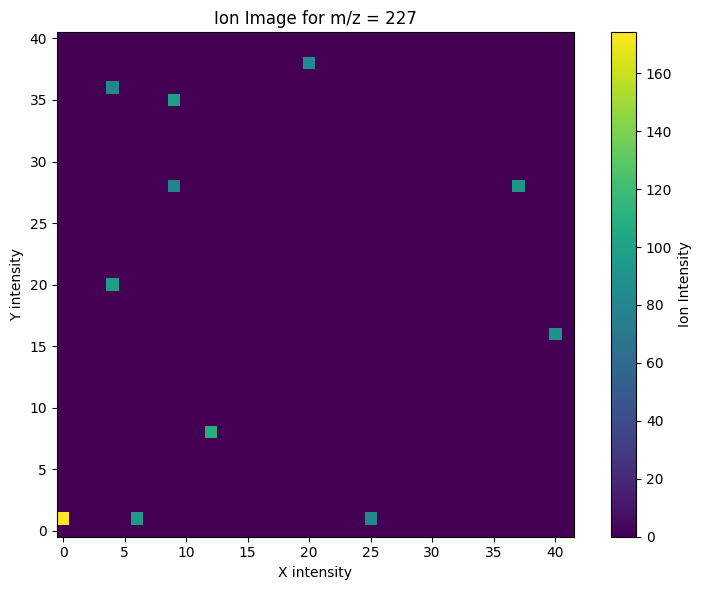

227.0000000000394 226.98000000003938 227.0200000000394


In [44]:

# Choose the m/z you want to plot  and tolerance
target_mz = 227
tolerance = 0.02

# Get image dimensions
all_coords = [coord for _, _, coord in my_spectra]
xs, ys = zip(*all_coords)
width = max(xs) + 1
height = max(ys) + 1
print(width,height)



# Create empty image
ion_image = np.zeros((height, width))

# Fill in the ion image with intensities for target m/z
times = 0 
for mzs, intensities, (x, y) in my_spectra:
    # Get mask of indices where mz is within target window
    mz_mask = (mzs >= target_mz - tolerance) & (mzs <= target_mz + tolerance)
    if np.any(mz_mask):
        times+=1
        ion_intensity = np.mean(intensities[mz_mask])
        ion_image[y, x] = ion_intensity
print(f"Points found", times)

# Plot the ion image
plt.figure(figsize=(8, 6))
plt.imshow(ion_image, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.title(f"Ion Image for m/z = {target_mz}")
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()
print(common_mzs[3850],common_mzs[3849],common_mzs[3851])

In [ ]:
# Save the processed data to npy files
np.save('../Data/LPS/control1_x.npy', X)
# np.save('../Data/LPS/control1_mzs.npy', common_mzs)
# np.save('../Data/LPS/control1_coords.npy', [coord for _, _, coord in my_spectra])

